# Ridge and Lasso Regression Assignment (Diabetes Dataset)

In this exercise, you will use the **Diabetes dataset** (built into scikit-learn) to explore how **Ridge** and **Lasso regression** handle correlated predictors and the effects of regularization. You will compare them to a standard **Linear Regression** model, visualize their coefficients, and interpret how regularization influences **model complexity** and **performance**.

You will also examine the role of **interaction features**, exploring how they can add flexibility to the model and help reduce bias.

We will conduct two sets of experiments:
1. Using only the original features, and
2. Using the original features plus interaction terms.

### Learning Objectives
By the end of this exercise, you will be able to:

- Apply **Ridge** and **Lasso regression** to control model complexity and prevent overfitting.  
- Use **cross-validation** to select the optimal level of regularization (`alpha`).  
- Interpret how regularization affects **coefficient magnitude**, **sparsity**, and **model interpretability**.  
- Evaluate how adding **interaction features** changes model bias, variance, and predictive performance.

### Step 1: Load & Understand the Diabetes Dataset

Let’s start by loading the dataset and reviewing the feature space. The code for this section is provided; you will write your own code for the remainder of this assignment.

In [1]:

from sklearn.datasets import load_diabetes
import pandas as pd

# Load dataset
data = load_diabetes(as_frame=True)
X = data.data
y = data.target

print(f"Shape: {X.shape}")
X.head()


Shape: (442, 10)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [2]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

**Feature descriptions**: Below is the feature descriptions for the diabetes dataset. Note that the data is already scaled.

In [3]:
feature_info = {
    "age": "Age (years)",
    "sex": "Sex (1 = male, 2 = female)",
    "bmi": "Body mass index (kg/m²)",
    "bp": "Average blood pressure",
    "s1": "TC – T-Cell count (cholesterol-related)",
    "s2": "LDL – Low-Density Lipoproteins (bad cholesterol)",
    "s3": "HDL – High-Density Lipoproteins (good cholesterol)",
    "s4": "TCH – Total Cholesterol",
    "s5": "LTG – Log of serum triglycerides level",
    "s6": "GLU – Blood sugar level (glucose)"
}

import pandas as pd
pd.DataFrame(feature_info.items(), columns=["Feature", "Description"])

,Feature,Description
0,age,Age (years)
1,sex,"Sex (1 = male, 2 = female)"
2,bmi,Body mass index (kg/m²)
3,bp,Average blood pressure
4,s1,TC – T-Cell count (cholesterol-related)
5,s2,LDL – Low-Density Lipoproteins (bad cholesterol)
6,s3,HDL – High-Density Lipoproteins (good choleste...
7,s4,TCH – Total Cholesterol
8,s5,LTG – Log of serum triglycerides level
9,s6,GLU – Blood sugar level (glucose)


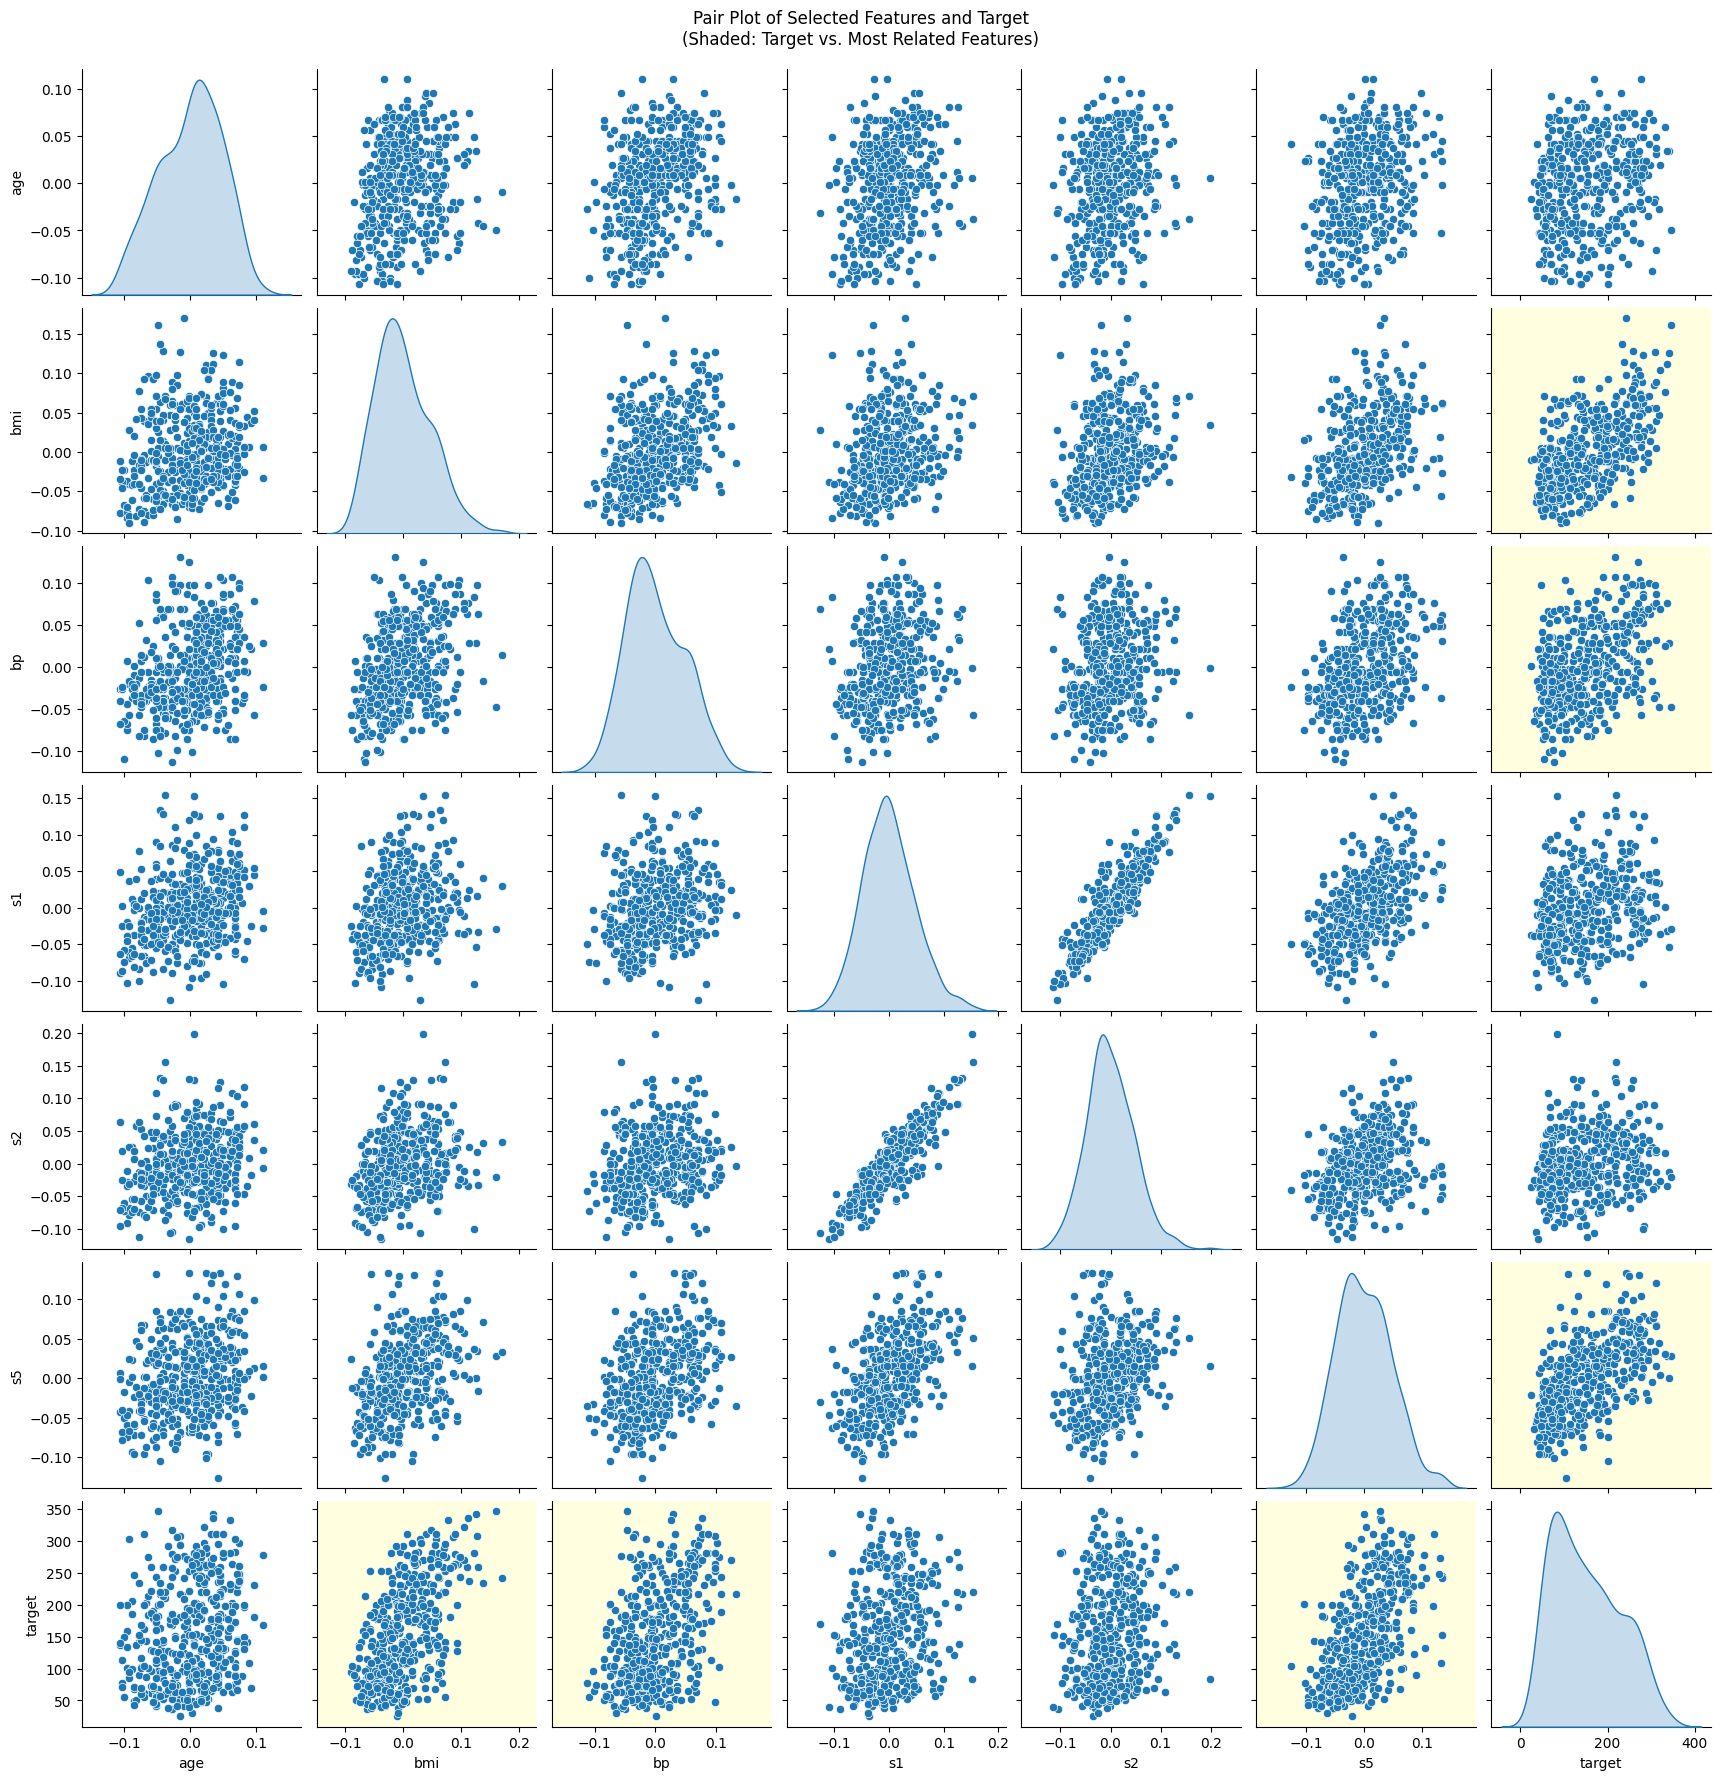

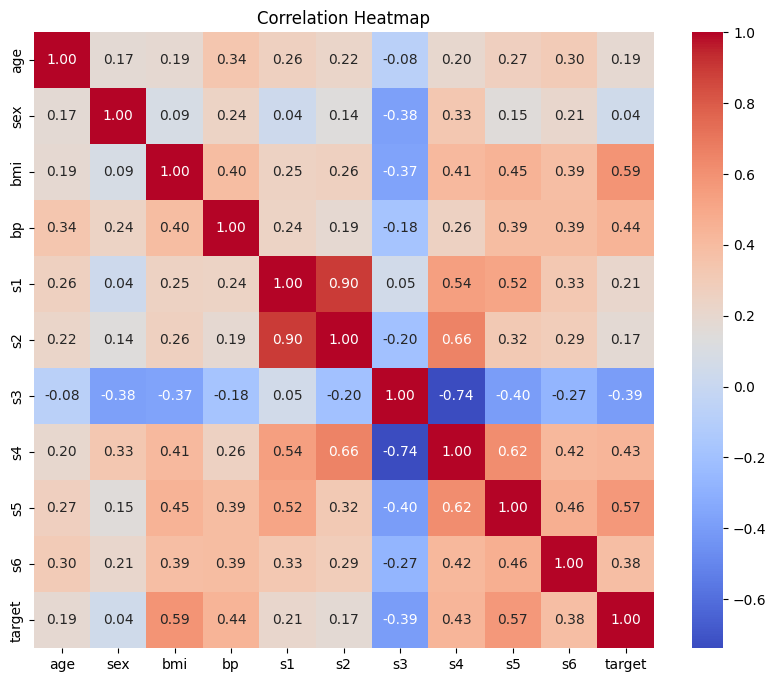

In [18]:
import seaborn as sns

import matplotlib.pyplot as plt

# Pair plot for the first few features and the target
# Highlight features most related to the target (highest correlation)
# We'll use 'bmi', 'bp', and 's5' as the most related features based on the heatmap/correlation matrix
highlight_features = ['bmi', 'bp', 's5']

df = X.copy()
df['target'] = y

# Pair plot with shaded background for target vs. important features
pairplot = sns.pairplot(df, vars=['age', 'bmi', 'bp', 's1', 's2', 's5', 'target'], diag_kind='kde', height=2.5)
for ax in pairplot.axes.flatten():
    if (ax.get_xlabel() == 'target' and ax.get_ylabel() in highlight_features) or (ax.get_ylabel() == 'target' and ax.get_xlabel() in highlight_features):
        ax.set_facecolor('lightyellow')  # Shade background only for target vs. highlight_features
plt.suptitle("Pair Plot of Selected Features and Target\n(Shaded: Target vs. Most Related Features)", y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

### Interpretation of Pairplot and Heatmap

#### Pairplot:
The pairplot provides a visual representation of the relationships between selected features (`age`, `bmi`, `bp`, `s1`, `s2`) and the target variable. Key observations:
- `bmi` and `bp` show a relatively strong positive relationship with the target variable, indicating that higher values of these features are associated with higher target values.
- Some features, such as `age`, show weaker or less clear relationships with the target variable.
- The diagonal KDE plots show the distribution of each feature, which appears to be centered around zero due to scaling.

#### Heatmap:
The heatmap displays the correlation matrix, showing the strength and direction of linear relationships between features and the target variable. Key observations:
- `bmi` has the highest positive correlation with the target variable (`0.586`), followed by `bp` (`0.441`) and `s5` (`0.566`).
- Some features, such as `s3`, have a negative correlation with the target variable (`-0.395`).
- Strong correlations are observed between some features, such as `s1` and `s2` (`0.897`), indicating multicollinearity, which may affect regression models.
- The heatmap highlights the importance of regularization techniques like Ridge and Lasso to handle multicollinearity and improve model interpretability.

# Section 1. Modeling with Original Features

Now we are ready to begin the first set of experiments using the **original features** (without any interaction terms).

Write the code for each empty section below. You may refer to examples from class or lab sessions as needed.

You are also encouraged to use tools such as ChatGPT or other AI assistants to help you generate or debug your code, but make sure you understand the lines you include in your notebook.

### Step 2: Split Data into Training and Test Sets

Use ``test_size= 0.2`` and ``random_state=42``.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Step 3: Standardize Features

Even though, the original features are scaled, following best practice, use ``StandardScaler`` to scale the features.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


### Step 4: Fit a Linear Regression Model

Create an object named ``lr`` to fit a linear regression model. Report the **R² score on the test set**.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression().fit(X_train_s, y_train)
r2_lr = r2_score(y_test, lr.predict(X_test_s))
print(f"R² (Linear Regression): {r2_lr:.3f}")


R² (Linear Regression): 0.453


### Step 5: Ridge Regression with Cross-Validation

Create an object named ``ridge`` to fit a 5-fold cross-validated Ridge regression model using ``alphas = [0.01, 0.1, 1, 10, 100]``. Report the **R² score** on the test set, and **the best alpha value**.

In [7]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)
ridge.fit(X_train_s, y_train)
r2_ridge = r2_score(y_test, ridge.predict(X_test_s))
print(f"R² (Ridge): {r2_ridge:.3f}, Best alpha: {ridge.alpha_}")


R² (Ridge): 0.457, Best alpha: 10.0


### Step 6: Lasso Regression with Cross-Validation

Create an object named ``lasso`` to fit a 5-fold cross-validated Lasso regression model using ``alphas = [0.001, 0.01, 0.1, 1, 10]`` and ``max_iter=10000``. Report the **R² score** on the test set, the **best alpha value**, and the **number of non-zero coefficients**.

In [8]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5, max_iter=10000)
lasso.fit(X_train_s, y_train)
r2_lasso = r2_score(y_test, lasso.predict(X_test_s))

print(f"R² (Lasso): {r2_lasso:.3f}, Best alpha: {lasso.alpha_}")
print(f"Non-zero coefficients: {(lasso.coef_ != 0).sum()} out of {len(lasso.coef_)}")


R² (Lasso): 0.467, Best alpha: 1.0
Non-zero coefficients: 9 out of 10


### Step 7: Lasso Regression with a Fixed Penalty

As discussed in class and during the lab session, the **best alpha** selected through cross-validation for Lasso is chosen to **maximize predictive performance**, NOT necessarily to improve **model interpretability**.

In this section, write code to fit a **Lasso regression** model with a larger, fixed value of ``alpha = 5`` (without cross-validation). Name the object ``lasso_c``; report the **R² score** on the test set and the **number of non-zero coefficients**.

In [9]:
from sklearn.linear_model import Lasso

lasso_c = Lasso(alpha=5)
lasso_c.fit(X_train_s, y_train)
r2_lasso_c = r2_score(y_test, lasso_c.predict(X_test_s))

print(f"R² (Lasso): {r2_lasso_c:.3f}")
print(f"Non-zero coefficients: {(lasso_c.coef_ != 0).sum()} out of {len(lasso_c.coef_)}")


R² (Lasso): 0.465
Non-zero coefficients: 5 out of 10


### Step 8: Identifying the Important Features

Next we want to create a plot to help us visualize which predictors remain active in the model and whether they have a positive or negative association with the target.

Create a horizontal bar chart showing the non-zero Lasso coefficients for ``alpha = 5``.

* Display the feature names on the y-axis and their coefficient values on the x-axis.
* Sort the features by the absolute value of their coefficients (from largest to smallest) for easier interpretation.

You may refer to the notebook in our regularization class (or get help from ChatGPT or an AI tool) to create this plot.


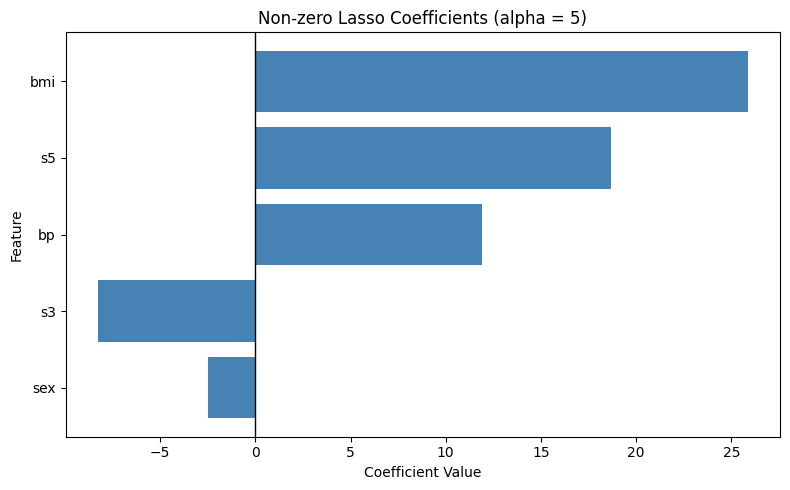

In [10]:
# Visualizing Non-Zero Lasso Coefficients (alpha = 5)

import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_c.coef_
})

# Filter out zero coefficients
nonzero_df = coef_df[coef_df['Coefficient'] != 0]

# Sort by absolute value for clearer visualization
nonzero_df = nonzero_df.reindex(nonzero_df['Coefficient'].abs().sort_values(ascending=True).index)

# Plot
plt.figure(figsize=(8,5))
plt.barh(nonzero_df['Feature'], nonzero_df['Coefficient'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Non-zero Lasso Coefficients (alpha = 5)')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

### Step 9: Reflection on Experiment 1

Answer the following questions:

1. Which model gives the highest R² on the test set?  
2. How do Ridge and Lasso coefficients compare to Linear Regression?  
3. How does increasing `alpha` affect model complexity for Lasso?  
4. Interpret the top 5 factors identified by Lasso regression.

# Section 2. Modeling with Original and Interaction Features

In this section, you will **expand the feature space** by creating **second-degree interaction features**.

### Step 10: Generate Polynomial Features

Use the ``PolynomialFeatures`` class from ``sklearn.preprocessing`` with the argument ``interaction_only=True`` to generate **only interaction terms** (no squared terms).

Name the new variables ``X_train_poly`` and ``X_test_poly``.

In [11]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = pf.fit_transform(X_train)
X_test_poly = pf.transform(X_test)

print(f"Feature space expanded from {X_train.shape[1]} to {X_train_poly.shape[1]} features.")


Feature space expanded from 10 to 55 features.


### Step 11: Standardize the New Expanded Feature Space

Name the new variables ``X_train_poly_s`` and ``X_test_poly_s``.

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_poly_s = scaler.fit_transform(X_train_poly)
X_test_poly_s = scaler.transform(X_test_poly)


### Step 12: Linear Regression Baseline (Polynomial Features)

Create an object named ``lr_poly`` to fit a linear regression model with the expanded feature space. Report the **R² score on the test set**.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr_poly = LinearRegression().fit(X_train_poly_s, y_train)
r2_lr_poly = r2_score(y_test, lr_poly.predict(X_test_poly_s))
print(f"R² (Linear Regression with Polynomial Features): {r2_lr_poly:.3f}")


R² (Linear Regression with Polynomial Features): 0.478


### Step 13: Ridge Regression with Cross-Validation

Create an object named ``ridge_poly`` to fit a 5-fold cross-validated Ridge regression model using ``alphas = [0.01, 0.1, 1, 10, 100]`` with the expanded feature space. Report the **R² score** on the test set, and **the best alpha value**.

In [19]:
from sklearn.linear_model import RidgeCV

ridge_poly = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])
ridge_poly.fit(X_train_poly_s, y_train)
r2_ridge_poly = r2_score(y_test, ridge_poly.predict(X_test_poly_s))
print(f"R² (Ridge + Polynomial): {r2_ridge_poly:.3f}, Best alpha: {ridge_poly.alpha_}")


R² (Ridge + Polynomial): 0.500, Best alpha: 100.0


### Step 14: Lasso Regression with Cross-Validation

Create an object named ``lasso_poly`` to fit a 5-fold cross-validated Lasso regression model using ``alphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1]`` and ``max_iter=500000``. Report the **R² score** on the test set, the **best alpha value**, and the **number of non-zero coefficients**. Note that, compared to Lasso CV with the original feature space, we have increased ``max_iter`` argument to ensure algorithm convergence; you can try a smaller value to see the warning message.

In [20]:
from sklearn.linear_model import LassoCV

lasso_poly = LassoCV(alphas=[0.001, 0.01, 0.05, 0.1, 0.5, 1], max_iter=500000)
lasso_poly.fit(X_train_poly_s, y_train)
r2_lasso_poly = r2_score(y_test, lasso_poly.predict(X_test_poly_s))

print(f"R² (Lasso + Polynomial): {r2_lasso_poly:.3f}, Best alpha: {lasso_poly.alpha_}")
print(f"Non-zero coefficients: {(lasso_poly.coef_ != 0).sum()} out of {len(lasso_poly.coef_)}")


R² (Lasso + Polynomial): 0.514, Best alpha: 1.0
Non-zero coefficients: 32 out of 55


### Step 15: Lasso Regression with a Fixed Penalty

Similar to Step 7, we can improve **model interpretability** by increasing alpha without a significant drop in predictive performance. Write code to fit a **Lasso regression** model with a larger, fixed value of ``alpha = 5`` (without cross-validation). Name the object ``lasso_poly_c``, and report the **R² score** on the test set and the **number of non-zero coefficients**.

In [22]:

from sklearn.linear_model import Lasso

lasso_poly_c = Lasso(alpha=5, max_iter=500000)
lasso_poly_c.fit(X_train_poly_s, y_train)
r2_lasso_poly_c = r2_score(y_test, lasso_poly_c.predict(X_test_poly_s))

print(f"R² (Lasso + Polynomial): {r2_lasso_poly_c:.3f}")
print(f"Non-zero coefficients: {(lasso_poly_c.coef_ != 0).sum()} out of {len(lasso_poly_c.coef_)}")


R² (Lasso + Polynomial): 0.490
Non-zero coefficients: 9 out of 55


### Step 16: Identifying the Important Features

Again we want to create a plot to help us visualize which predictors remain active in the model and whether they have a positive or negative association with the target. Create a horizontal bar chart showing the non-zero Lasso coefficients for ``alpha = 5``. Follow the instructions in Step 8 for guidance.

**Hint**: the top 5 features should be identical to plot from Step 8.

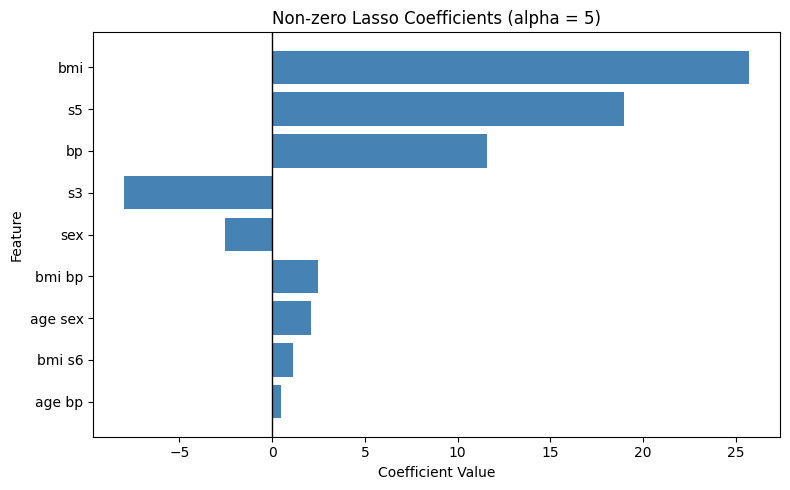

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of feature names and their coefficients
# Get feature names after polynomial expansion
feature_names = pf.get_feature_names_out(X_train.columns)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_poly_c.coef_
})

# Filter out zero coefficients
nonzero_df = coef_df[coef_df['Coefficient'] != 0]

# Sort by absolute value for clearer visualization
nonzero_df = nonzero_df.reindex(nonzero_df['Coefficient'].abs().sort_values(ascending=True).index)

# Plot
plt.figure(figsize=(8,5))
plt.barh(nonzero_df['Feature'], nonzero_df['Coefficient'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Non-zero Lasso Coefficients (alpha = 5)')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

# Section 3. Conclusion

Given everything you have explored in this exercise (and what we discussed in the course) about **regularization, interaction terms, overfitting**, and **model generalizability**, what is your perspective on the **bias–variance trade-off** and the **interpretability trade-off** for this dataset?

Take a moment to reflect and collect your thoughts before revealing my answer below.

<details>
<summary>Click to reveal my answer</summary>

**Conclusion (my version)**

Across both experiments, **regularization consistently improves model performance**, confirming its role in **reducing variance** and **enhancing generalization**.

When we extend the feature space to include **interaction terms**, we observe a modest additional improvement in test-set R², indicating that these nonlinear interactions capture a small portion of residual structure that the purely linear model could not explain.

However, as seen from both the performance metrics and the most influential predictors identified by Lasso (α = 5), the qualitative story remains the same: the model’s insights and key drivers of diabetes progression are largely unchanged.

This suggests that, for this dataset, the relationships between predictors and the target are **predominantly linear and additive**, and the marginal gains from including polynomial interactions may not justify the added complexity or overfitting risk for future data.

In practice, this highlights an important modeling principle:

<u>**Regularization helps control variance, while model expansion helps reduce bias; but the goal is not maximum complexity, it’s meaningful simplicity**.<u>